In [ ]:
import numpy as np
import pandas as pd
import re
import random
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from collections import defaultdict, Counter
import tqdm

In [ ]:
books = pd.read_csv("BX-Books.csv")
interactions = pd.read_csv("BX-Book-Ratings.csv", sep=";", encoding = "ISO-8859-1")
users = pd.read_csv('BX-Users.csv', delimiter=';', encoding = 'ISO-8859-1')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Предобработка

In [ ]:
interactions = interactions[interactions["Book-Rating"] != 0]

In [ ]:
books_meets = interactions.groupby("ISBN")["User-ID"].count().reset_index().rename(columns={"User-ID": "user_num"})

In [ ]:
user_meets = interactions.groupby("User-ID")["ISBN"].count().reset_index().rename(columns={"ISBN": "books_num"})

In [ ]:
interactions = interactions.merge(books_meets, on=["ISBN"]).merge(user_meets, on=["User-ID"])

In [ ]:
interactions = interactions[(interactions["user_num"] > 5) & 
                            (interactions["books_num"] > 5) &
                            (interactions["books_num"] < 200)]

In [ ]:
interactions = interactions.merge(books[["ISBN", "Image-URL-M", "Book-Title"]].rename(
    columns={"Image-URL-M": "picture_url"}), on=["ISBN"])

In [ ]:
# чистим ISBN

interactions = interactions[interactions['ISBN'].map(lambda x: bool(re.match('\d{10}', x)))]

Согласуем таблицы - удаляем пользователей, которые не совершали взаимодействий, так как в рамках рассматриваемой задачи они нам бесполезны:

In [ ]:
users = users[users['User-ID'].isin(interactions['User-ID'])]

In [ ]:
# удаляем детей и стариков

users = users.drop(users[(users['Age'] < 6) | (users['Age'] > 120)].index).reset_index(drop=True)

In [ ]:
# согласуем таблицы

interactions = interactions[interactions['User-ID'].isin(users['User-ID'])].reset_index(drop=True)

In [ ]:
# проверяем, что никто не поставил книге оценку несколько раз

interactions.groupby(['User-ID'])['ISBN'].value_counts().value_counts()

1    100753
Name: ISBN, dtype: int64

In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
interactions["product_id"] = le.fit_transform(interactions["ISBN"])
interactions["vid"] = le.fit_transform(interactions["User-ID"])

In [ ]:
# разобьём Location на 3 столбца

users = users.join(users['Location'].str.split(", ", n=2, expand=True))
users = users.drop(['Location'], axis=1)
users = users.rename(columns={0: 'city', 1: 'region', 2: 'country'})

Далее удаляем строки, где country NaN - заполнить их данными невозможно, поэтому они нам бесполезны. NaN'ы в Age заполним медианными значениями по региону (если по региону заполнить невозможно - по стране). Оставшихся NaN'ов в Age всего 8, эти строки можно просто удалить как бесполезные (человек не указал возраст и он единственный в своей стране - дать ему рекомендации по этим данным не сможем).

In [ ]:
users = users[users['country'].notna()]
users['Age'] = users.groupby(['region'])['Age'].transform(lambda x: x.fillna(x.median()))
users['Age'] = users.groupby(['country'])['Age'].transform(lambda x: x.fillna(x.median()))
users = users[users['Age'].notna()].reset_index(drop=True)

In [ ]:
users

,User-ID,Age,city,region,country
0,8,32.0,timmins,ontario,canada
1,99,42.0,franktown,colorado,usa
2,114,57.0,ligonier,pennsylvania,usa
3,242,37.0,neuffen,baden-wuerttemberg,germany
4,243,37.0,arden hills,minnesota,usa
...,...,...,...,...,...
10392,278668,48.0,madrid,madrid,spain
10393,278694,57.0,montgomery,alabama,usa
10394,278843,28.0,pismo beach,california,usa
10395,278851,33.0,dallas,texas,usa


# Кластеризация по личным данным

In [ ]:
users1 = users.copy()

In [ ]:
# минимаксно нормализуем возраста

from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()
users1['Age_norm'] = minmax.fit_transform(users1['Age'].values.reshape(-1, 1))
users1['Age_norm'] = users1['Age_norm'].transform(lambda x: x+1)

In [ ]:
# создаём словарь из данных пользователей

users_dict = users1.iloc[:,2:].to_dict(orient='records')
users1 = users1.drop(['Age_norm'], axis=1)

In [ ]:
# векторизуем словарь

from sklearn.feature_extraction import DictVectorizer

vect = DictVectorizer()
users_vect = vect.fit_transform(users_dict)

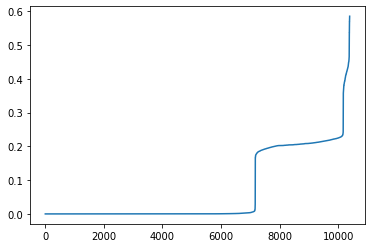

In [ ]:
# подбираем параметры DBSCAN

from sklearn.neighbors import NearestNeighbors

min_pts = 9
neighbors = NearestNeighbors(n_neighbors=min_pts, metric='cosine')
neighbors.fit(users_vect)
dist0, idx = neighbors.kneighbors(users_vect, return_distance=True)
dist = dist0[:, 1]
dist = np.sort(dist)
plt.plot(dist)

In [ ]:
# кластеризация

from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.25, min_samples=9, metric='cosine')
dbscan.fit(users_vect)
users1['cluster'] = dbscan.labels_
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41])

In [ ]:
# проверяем разбиение

users1['cluster'].value_counts()

 1     7302
-1      683
 0      460
 3      292
 9      240
 4      189
 2      179
 7      122
 15      84
 6       69
 14      67
 11      59
 13      58
 10      45
 27      39
 17      39
 19      35
 16      31
 33      30
 30      27
 12      26
 18      25
 22      25
 24      23
 28      20
 36      19
 26      18
 32      17
 20      17
 25      16
 29      15
 21      14
 8       12
 5       12
 37      11
 40      10
 35      10
 34      10
 31      10
 23      10
 41       9
 38       9
 39       9
Name: cluster, dtype: int64

In [ ]:
# удаляем выбросы

users1 = users1[users1['cluster'] != -1]

In [ ]:
# создадим новую таблицу, которая свяжет кластеры и книги

inter_1 = interactions.copy()
inter_1 = inter_1.drop(['user_num', 'books_num', 'product_id', 'vid'], axis=1)
inter_1 = inter_1[inter_1['User-ID'].isin(users1['User-ID'])].reset_index(drop=True)
inter_1['cluster'] = inter_1['User-ID'].copy()
inter_1['cluster'] = inter_1['cluster'].replace(users1.set_index('User-ID')['cluster'])

In [ ]:
# вычисляем для каждой книги средний рейтинг по кластеру

inter_2 = inter_1.groupby(['cluster','ISBN'])['Book-Rating'].mean()
inter_3 = inter_2.index.to_frame(index=False)
inter_3['Mean-Rating'] = inter_2.values
inter_3 = inter_3.sort_values(by=['cluster', 'Mean-Rating'], ascending=False).reset_index(drop=True)

In [ ]:
inter_3.head()

,cluster,ISBN,Mean-Rating
0,41,0140440224,10.0
1,41,0345273303,10.0
2,41,0380570009,10.0
3,41,0399141146,10.0
4,41,0786865482,10.0


In [ ]:
# составляем рекомендации для рандомного пользователя

ID = random.choice(users1['User-ID'])
cluster_ID = users1.loc[users1[users1['User-ID'] == ID].index.values[0]]['cluster']
ISBNs_ID = inter_3.loc[inter_3[inter_3['cluster'] == cluster_ID].index.values[:10]]['ISBN'].to_list()

In [ ]:
def get_rec(ISBNs_ID, ID):
  print('For user ', ID, 'can be recommended:\n')
  for i in range(len(ISBNs_ID)):
    ISBN = ISBNs_ID[i]
    print(i+1,'. ', interactions.loc[interactions[interactions['ISBN'] == ISBN].index.values[0]]['Book-Title'])
    response = requests.get(interactions.loc[interactions[interactions['ISBN'] == ISBN].index.values[0]]['picture_url'])
    img = Image.open(BytesIO(response.content))
    imgplot = plt.imshow(img)
    plt.show()

For user  9183 can be recommended:

1 .  Heart Songs and Other Stories


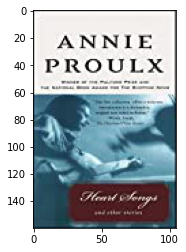

2 .  CRY THE BELOVED COUNTRY (Scribner Classic)


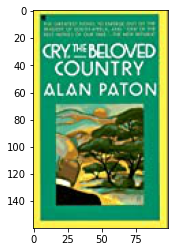

3 .  Elements of Style 3ED


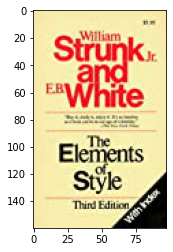

4 .  Boy Meets Girl


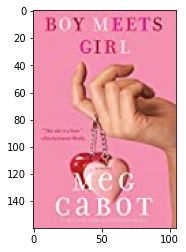

5 .  Beauty Fades, Dumb Is Forever: The Making of a Happy Woman


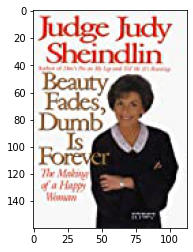

6 .  Falling Up


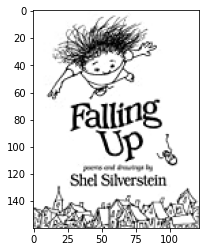

7 .  The Giving Tree


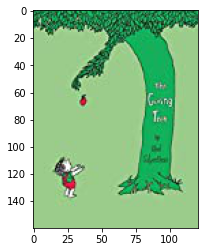

8 .  Where the Sidewalk Ends : Poems and Drawings


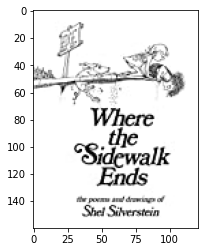

9 .  American Gods : A Novel


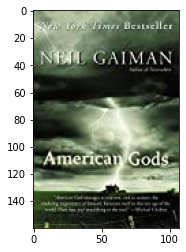

10 .  The Phantom of the Opera: The Original Novel


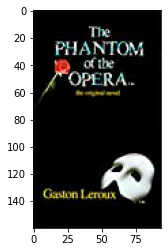

In [ ]:
get_rec(ISBNs_ID, ID)

# Совстречаемость

In [ ]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

def rec_imaging(product_ids, content_dict, measure=None, top_n=5):
    picture_urls = [content_dict[i] for i in product_ids]
    cnt = 0
    for idx, chunk in enumerate(chunks(picture_urls, top_n)):
        fig = plt.figure(figsize=(20, 4))
        for n, i in enumerate(chunk):
            try:
                r = requests.get(i)
                im = Image.open(BytesIO(r.content))

            except:
                print('Something went wrong with {url}'.format(url=i))
                continue

            a = fig.add_subplot(1, top_n, n + 1)
            if measure is not None:
                a.title.set_text("measure = {}".format(np.round(measure[cnt], 4)))
                cnt += 1
            plt.imshow(im)
            plt.axis('off')
        plt.show()

In [ ]:
class Recomendations():
    def __init__(self, Int):
        self.product_id_to_url = {}
        for i in Int[["product_id", "picture_url"]].drop_duplicates().values:
            self.product_id_to_url[i[0]] = i[1]
        self.interactions = Int
        
    def coocurrency_count(self):
        Int = self.interactions[["vid", "product_id", "Book-Rating"]].drop_duplicates()
        user_products = Int.groupby(["vid"])["product_id"].apply(list).reset_index()
        product_num = [len(i) for i in user_products["product_id"]]
        user_products["prod_num"] = product_num
        user_products = user_products[user_products["prod_num"] > 1]
        cooc = defaultdict(list)
        # считаем для 5000, чтобы время расчёта было допустимым
        for i in tqdm.tqdm_notebook(user_products.values[:5000]):
            for j in range(len(i[1])):
                for k in range(len(i[1])):
                    if j != k:
                        key = str(i[1][j]) + "_" + str(i[1][k])
                        if key in cooc.keys():
                            cooc[key] += (Int.loc[(Int['vid'] == i[0]) & (Int['product_id'] == i[1][j])]['Book-Rating'].iloc[0] + Int.loc[(Int['vid'] == i[0]) & (Int['product_id'] == i[1][k])]['Book-Rating'].iloc[0])/2
                        else:
                            cooc[key] = (Int.loc[(Int['vid'] == i[0]) & (Int['product_id'] == i[1][j])]['Book-Rating'].iloc[0] + Int.loc[(Int['vid'] == i[0]) & (Int['product_id'] == i[1][k])]['Book-Rating'].iloc[0])/2
        cooc_list = []
        for i, j in cooc.items():
            if j != 1:
                cooc_list.append(i.split("_") + [j])
        self.cooc_rec = pd.DataFrame(cooc_list, columns=["item1", "item2", "measure"])
    
    def get_rec(self, i, show=False):
        recs = self.cooc_rec[self.cooc_rec["item1"] == str(i)].sort_values("measure", ascending=False).head(10)
        print(u"For book ", interactions['Book-Title'][i])
        rec_imaging([i], self.product_id_to_url)
        print(u"can be recommended:")
        rec_imaging(recs["item2"].values.astype(int), self.product_id_to_url, recs["measure"].values.astype(int))

In [ ]:
cooc_rec = Recomendations(interactions)
cooc_rec.coocurrency_count()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


For book  Portrait in Sepia : A Novel


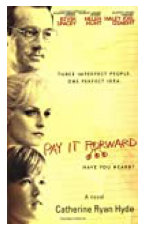

can be recommended:


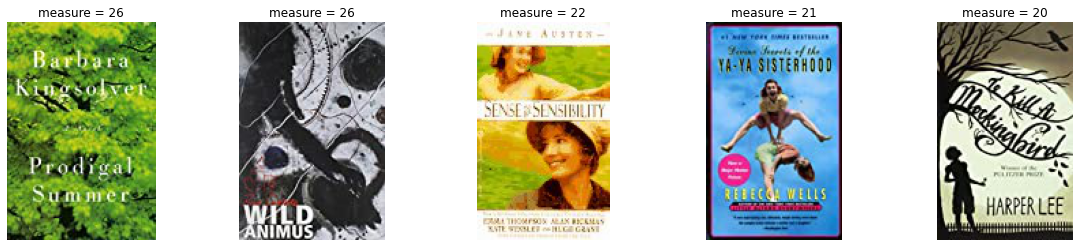

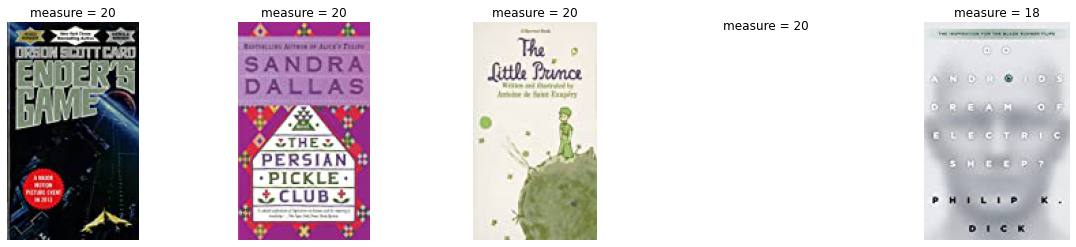

In [ ]:
cooc_rec.get_rec(random.choice(interactions['product_id'].values[:5000]))